<a href="https://colab.research.google.com/github/qazwsx351789/QSVM/blob/main/QSVM_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 28.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse

from qutip import expect , Qobj
import qutip
import pandas as pd
import math

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [3]:
import qutip
from qutip import Qobj,basis
from qutip import sigmax , sigmaz , sigmay
import qutip
import math
from qutip.metrics import fidelity
import math
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor

Connect to your goole drive.

# Prepare MNIST data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Show matplotlib graphs in your notebook
%matplotlib inline

In [179]:
from scipy.io import loadmat
import random

train_num=1000
test_num=300
mnist = loadmat('/content/drive/MyDrive/QSVM/mnist.mat') # change the file path according to the path where you put mnist.mat on your Google Drive.

index=[i for i in range(len(mnist['traindata'][:10000]))]
random.shuffle(index)
mnist['traindata'][:10000]=mnist['traindata'][index]
mnist['trainlabels'][:10000]=mnist['trainlabels'][index]

traindata = mnist['traindata'][:train_num]
trainlabels = mnist['trainlabels'].ravel()[:train_num]
testdata = mnist['traindata'][train_num:train_num+test_num]
testlabels = mnist['trainlabels'].ravel()[train_num:train_num+test_num]


print(traindata.shape)
print(trainlabels.shape)
print(testdata.shape)
print(testlabels.shape)


(1000, 784)
(1000,)
(300, 784)
(300,)


Visulize the images and labels

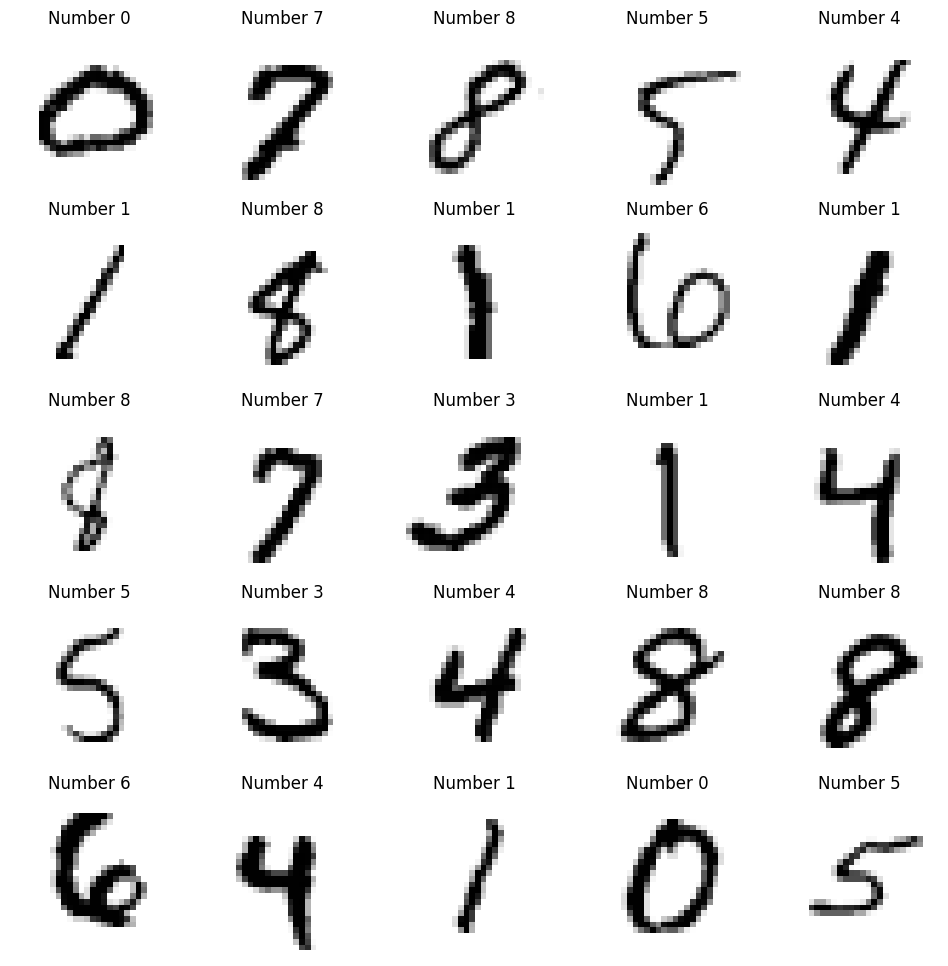

In [180]:

fig, axs = plt.subplots(5, 5, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
  ax.imshow(traindata[i].reshape((28, 28)), cmap=cm.gray_r)
  ax.axis('off')
  ax.set_title('Number {}'.format(trainlabels[i]))

## PCA

### approach1


In [181]:
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler
#step1
scaler = StandardScaler()
train = scaler.fit_transform(traindata)
test = scaler.fit_transform(testdata)

#step2
cov_train = np.cov(train.T)

#step3
eig_vals, eig_vecs = LA.eig(cov_train)

#step4
sort_indices = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sort_indices]
eig_vecs = eig_vecs[:, sort_indices]

#step5
k = 10 ## The number of features after PCA
eig_vec = eig_vecs[:, :k]


#step6
train_pca = np.real(np.dot(train, eig_vec))
test_pca = np.real(np.dot(test, eig_vec))


In [182]:
imax=0
imin=0
for ll in train_pca:
  imax=max(imax,max(ll))
  imin=min(imin,min(ll))
print("imax=",imax)
print("imin=",imin)

imax= 18.936204024822935
imin= -30.409294096245713


In [183]:
# Normalize
Norm=math.pi
train_pca_q=[]
test_pca_q=[]
for i,ll in enumerate(train_pca):
  train_pca_q.append(train_pca[i]/max(imax,abs(imin))*Norm)

for i,ll in enumerate(test_pca):
  test_pca_q.append(test_pca[i]/max(imax,abs(imin))*Norm)

### approach 2

In [184]:
# pca_on = True
# PCA_n = 10
# if pca_on :
#   color = np.array([1,1,0,1])
#   pca = PCA(n_components=PCA_n)
#   pca.fit(train)
#   train_pca = pca.transform(train)
#   test_pca = pca.transform(test)
#   print(train_pca.shape , test_pca.shape)

# Qmapping

In [62]:
sigx = sigmax()
sigz = sigmaz()
sigy = sigmay()
iid = qutip.qeye(2)
rr = Qobj([[0,0],[0,1]])

def gst(d):
  b = [basis(2,0) for i in range(d)]
  return tensor(b)
def form_op(tg,operator , d) :
    r = iid
    if 0 in tg :
        r = operator
    for i in range(1,d):
        if i in tg :
            r = tensor(r , operator)
        else :
            r = tensor(r , iid)
    return r
def dynamics(d):
  h = form_op([0] , sigx , d)
  for i in range(1,d) :
    h += form_op([i],sigx ,d)
  return h

def EncodingP(d,data):
  h = form_op([0] , sigz , d)*data[0]
  for i in range(1,d) :
    h += form_op([i],sigz ,d)*data[i]
  return h

def Entangle(config , d):
  for idx ,x in enumerate(config) :
    for idy ,y in enumerate(x) :
      try :
        h += y * form_op([idx , idy] , rr ,d)
      except :
        h  = y * form_op([idx , idy] , rr ,d)
  return h
def Constant_H(config , d, Ruby) :
  return Ruby*dynamics(d) + Entangle(config , d)

In [63]:
dim = 10
left_gst = gst(dim).dag()
right_gst = gst(dim)

In [64]:
def HMap(config ,d ,Ruby) :
  CH = Constant_H(config , d, Ruby)
  return CH
def evolution(H,t) :
  return (-1j * H * t).expm()
def k_value(left , right) :
  k = (left.dag() * right)[0][0][0]
  return (k * k.conjugate()).real

In [65]:
def Qmap(config , d,t,Data ,Ruby):
  rs = []
  h = HMap(config ,d ,Ruby)
  right_gst = gst(d)
  ev=evolution(h,t)
  for da in Data:
    EP=(-1j * EncodingP(d,da)).expm()
    state= EP * right_gst
    state= ev * state
    state= EP * state
    rs.append(state)
  return rs
def get_q_kernel(state1 , state2 , status = "train" ):
  k_matrix = []
  for i ,s in enumerate(state1) :
    _k = []
    for j  , st in enumerate(state2) :
      if i >= j or status == "test":
        _k.append(k_value(s,st))
      else :
        _k.append(0)
    k_matrix.append(_k)
  if status == "train" :
    for idy , km in enumerate(k_matrix) :
      for idx , k in enumerate(km) :
          if k == 0 :
              k_matrix[idy][idx] = k_matrix[idx][idy]
  return np.array(k_matrix)

In [35]:
# kernel transformation, visualization
def diagnal(target , diag):
  for k in range(0,len(target)) :
    target[k][k] = diag
  return target
def rescale(target):
  _min = np.min(target)
  _max = np.max(target)
  delta  = _max - _min
  for i in range(0,len(target)) :
    for j in range(0,len(target[0])) :
      target[i][j] = (target[i][j] - _min) / delta
  return target
def show_kmatrix(test=[], train = [],name = ""):
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  # if test != [] :
  a1=axs[0].imshow(np.asmatrix(test),
                interpolation='nearest', origin='upper', cmap='Blues')
  plt.colorbar(a1)
  axs[0].set_title("testing kernel matrix")
  # if train != [] :
  a2=axs[1].imshow(np.asmatrix(train),
                interpolation='nearest', origin='upper', cmap='Blues')
  plt.colorbar(a2)
  axs[1].set_title("training kernel matrix")
  if name == "" :
    plt.show()
  else :
    plt.savefig(name)

#Kernal Function

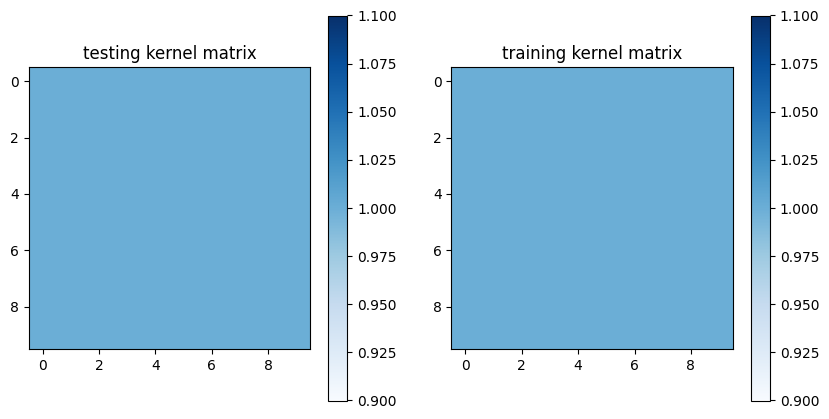

In [198]:
dim = k
left_gst = gst(dim).dag()
right_gst = gst(dim)
Roby=1
t = np.pi*1
config = np.ones([dim ,dim])
# for idx , cf in enumerate(config) :
#   for idy , c in enumerate(cf) :
#     if idx < 10:
#       config[idx][idy] = 1
show_kmatrix(train = config , test = config,name = "")

In [199]:
qx_train_lst = Qmap(config , dim ,t ,train_pca_q, Roby)
qx_test_lst = Qmap(config , dim ,t ,test_pca_q, Roby)

In [200]:
target_kernel = get_q_kernel(qx_train_lst,qx_train_lst)

In [201]:
test_kernel = get_q_kernel(qx_test_lst,qx_train_lst , status = "test")

In [202]:
target_kernel[0][0],target_kernel[1][1]

(1.0000000000000129, 1.0000000000000124)

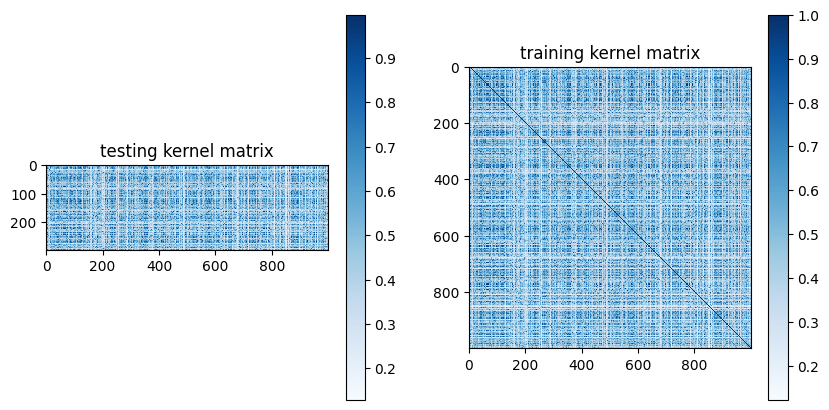

In [203]:
show_kmatrix(train = target_kernel , test = test_kernel,name = "qkernel")

# SVM

In [218]:
from sklearn.svm import SVC

clf = SVC(kernel="linear",C=10.0)
clf.fit(train_pca, trainlabels)

SVC(C=10.0, kernel='linear')


Evaluate the classification accuracy on the test set.

In [219]:
y_pred = clf.predict(test_pca)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.7833333333333333



Try using a different kernel type, change the kernal from ‘linear’ to ‘rbf’ (radial basis function) and evaluate the classification accuracy on the validation set.

In [206]:
clf = SVC(kernel="rbf",C=1.0)
clf.fit(train_pca, trainlabels)
y_pred = clf.predict(test_pca)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.8366666666666667


Fix the kernel type to be ‘rbf’ and try different sets of regularization parameters C ∈ {0. 1, 0. 5, 1. 0, 5. 0, 10. 0}, and report all the classification accuracies on the test set.

In [207]:
C_list = [0.1, 0.5, 1.0, 5.0, 10.0]
for c in C_list:
  clf = SVC(kernel="rbf",C=c)
  clf.fit(train_pca, trainlabels)
  y_pred = clf.predict(test_pca)
  accuracy = np.mean(y_pred == testlabels)
  print("C={},Accuracy:{}".format(c,accuracy))
  print("\n")
#C represents the penalty coefficient for misclassification,A larger value of C will make the model strictly classify all samples correctly.
#C=10 give me the best accurarcy

C=0.1,Accuracy:0.78


C=0.5,Accuracy:0.82


C=1.0,Accuracy:0.8366666666666667


C=5.0,Accuracy:0.8333333333333334


C=10.0,Accuracy:0.8333333333333334




In [220]:
clf = SVC(kernel="precomputed",C=10.0)
clf.fit(target_kernel, trainlabels)

SVC(C=10.0, kernel='precomputed')

In [221]:
y_pred = clf.predict(test_kernel)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.83
